In [4]:
!pip install -q tensorflow gradio

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr
import os


 TensorFlow version: 2.19.0


In [5]:
label_map = {
    "0": "Speed Limit",
    "1": "Stop",
    "2": "Turn left",
    "3": "Turn right",
    "4": "no entry towards left",
    "5": "no entry towards right",
    "6": "no entry",
    "7": "speed limit 40",
    "8": "speed limit 30",
    "9": "towards right",
    "10": "Prohibited area",
    "11": "no less than 30",
    "12": "towards left"
}


In [6]:
from google.colab import files
import zipfile, os

zip_path = "/content/Traffic-Sign-Detection-master.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/traffic_sign_data")

print("Files extracted to:", os.listdir("/content/traffic_sign_data"))


Files extracted to: ['Traffic-Sign-Detection-master']


In [7]:
data_dir = "/content/traffic_sign_data/Traffic-Sign-Detection-master/dataset"

IMG_SIZE = 64
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 80% training, 20% validation
    subset="training",
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=123
)

class_names = train_ds.class_names
print("Detected Classes:", class_names)


Found 1474 files belonging to 13 classes.
Using 1180 files for training.
Found 1474 files belonging to 13 classes.
Using 294 files for validation.
Detected Classes: ['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']


In [8]:
def normalize_img(img, label):
    return tf.cast(img, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,877 (2.61 MB)

 Trainable params: 684,877 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - accuracy: 0.4063 - loss: 1.8690 - val_accuracy: 0.8946 - val_loss: 0.5738
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.8554 - loss: 0.5349 - val_accuracy: 0.9728 - val_loss: 0.1464
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9532 - loss: 0.1878 - val_accuracy: 0.9796 - val_loss: 0.0692
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9647 - loss: 0.1465 - val_accuracy: 0.9796 - val_loss: 0.0705
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9828 - loss: 0.0709 - val_accuracy: 0.9898 - val_loss: 0.0401
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9904 - loss: 0.0275 - val_accuracy: 0.9966 - val_loss: 0.0206
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9940 - loss: 0.0310 - val_accuracy: 0.9932 - val_loss: 0.0168
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9941 - loss: 0.0263 - val_accuracy: 

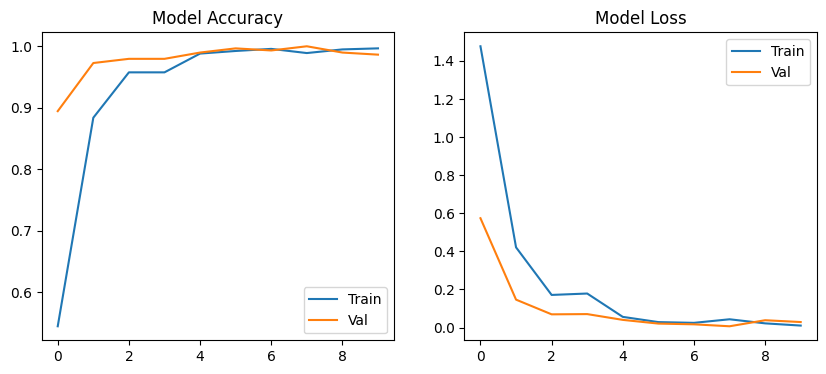

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend()
plt.title("Model Loss")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


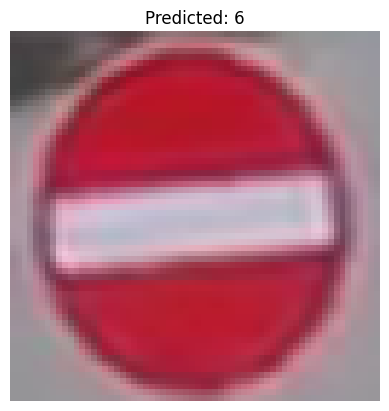

In [12]:
import random
from PIL import Image

# Pick a random image path
random_class = random.choice(class_names)
class_path = os.path.join(data_dir, random_class)
img_path = os.path.join(class_path, random.choice(os.listdir(class_path)))

# Load and predict
img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
img_arr = np.expand_dims(np.array(img)/255.0, axis=0)
pred = model.predict(img_arr)
predicted_class = class_names[np.argmax(pred)]

plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


In [13]:
def predict(img):
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.expand_dims(np.array(img)/255.0, axis=0)
    pred = model.predict(img)
    class_idx = np.argmax(pred)
    class_label = class_names[class_idx]

    # Use our label_map to convert number → name
    readable_label = label_map.get(class_label, f"Class {class_label}")
    confidence = float(np.max(pred))
    return {readable_label: confidence}



In [14]:
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Traffic Sign Recognition",
    description="Upload a traffic sign image to predict its class name."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d2a978d8781f3e0547.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
